In [1]:
import sys

In [2]:
import gammapy
import matplotlib.pylab as plt
import numpy as np
import pyximport
import yaml
from gammapy.datasets import Datasets
from gammapy.modeling import Fit, Parameter, Parameters
from gammapy.modeling.models import FoVBackgroundModel, Models

In [3]:
from matplotlib import rc
from scipy.interpolate import interp2d

# import random
sys.path.append("/home/katrin/Documents/nuisance_summary/")
sys.path.append("../../../")
import Dataset_load  # noqa: E402
from Dataset_Creation import sys_dataset  # noqa: E402

print(f"loaded gammapy version: {gammapy.__version__} ")
print("Supposed to be 1.0 (21-12-2022)")
rc("font", **{"family": "serif", "serif": ["Computer Modern"]})
rc("text", usetex=True)
pyximport.install()

loaded gammapy version: 0.1.dev19174+g56b5bdf 
Supposed to be 1.0 (21-12-2022)


(None, <pyximport.pyximport.PyxImporter at 0x7fecc0266220>)

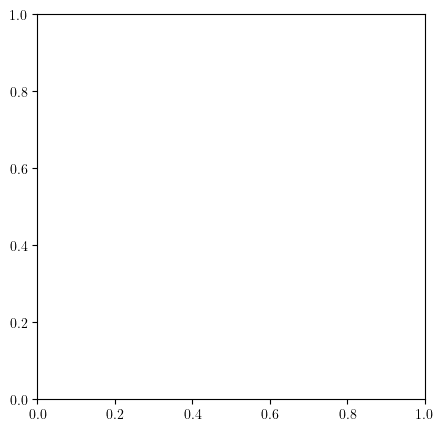

In [4]:
savefig = 1
picformat = "png"
fig, a_fake = plt.subplots(1, 1, figsize=(5.0, 5.0))

## Methods


In [5]:
def compute_fraction(Ls_new, x_new, y_new, threshold, plot=False):
    tot_int = np.sum(Ls_new)
    offset = Ls_new.min() + threshold
    inside = Ls_new * (Ls_new >= offset)
    fraction_inside = np.sum(inside) / tot_int
    if plot:
        fig, ax = plt.subplots(
            1,
            1,
        )
        im = ax.pcolormesh(x_new, y_new, Ls_new)
        fig.colorbar(im)
        ax.set_title(f"frac inside : {fraction_inside * 100:.4} %")

        ax.contour(
            x_new, y_new, Ls_new, colors=("gold",), levels=[Ls_new.min() + threshold]
        )
    return fraction_inside


def plot_L(
    Ls_new,
    x_new,
    y_new,
    threshold,
    find_min,
    color="red",
    ax=None,
    fig=None,
    cbar=True,
    cmap="viridis",
):
    index_min, index_max, ampli_min, ampli_max, index_best, ampli_best = compute_errors(
        Ls_new, x_new, y_new, threshold, find_min=find_min
    )
    if ax is None:
        fig, ax = plt.subplots(
            1,
            1,
        )

    im = ax.pcolormesh(x_new, y_new, Ls_new, cmap=cmap, rasterized=True)
    if cbar:
        fig.colorbar(im)

    CS = ax.contour(
        x_new, y_new, Ls_new, colors=(color,), levels=[Ls_new.min() + threshold]
    )
    # ax.clabel(CS, CS.levels, inline=True, fmt='$1\\sigma$', fontsize=12)

    plot_errors(
        ax,
        x_new,
        y_new,
        index_min,
        index_max,
        ampli_min,
        ampli_max,
        index_best,
        ampli_best,
        color,
    )

    ax.plot(ampli_best, index_best, "x", color=color)

    ax.set_ylabel(f"Amplitude [{a_unit}]")
    ax.set_xlabel("Index []")
    return CS


def plot_errors(
    ax,
    x_new,
    y_new,
    index_min,
    index_max,
    ampli_min,
    ampli_max,
    index_best,
    ampli_best,
    color,
):
    linewidth = 2

    ax.hlines(
        y=index_min,
        xmin=x_new[0],
        xmax=x_new[-1],
        color=color,
        linestyle="dotted",
        linewidth=linewidth,
    )
    ax.hlines(
        y=index_max,
        xmin=x_new[0],
        xmax=x_new[-1],
        color=color,
        linestyle="dotted",
        linewidth=linewidth,
    )

    ax.vlines(
        x=ampli_min,
        ymin=y_new[0],
        ymax=y_new[-1],
        color=color,
        linestyle="dotted",
        linewidth=linewidth,
    )
    ax.vlines(
        x=ampli_max,
        ymin=y_new[0],
        ymax=y_new[-1],
        color=color,
        linestyle="dotted",
        linewidth=linewidth,
    )


def compute_errors(Ls_new, x_new, y_new, threshold, find_min):
    offset = Ls_new.min() + threshold
    if offset > 0:
        inside = Ls_new * (Ls_new < offset)
    else:
        inside = Ls_new * (Ls_new >= offset)
    if find_min:  # find min:
        pos = np.where(inside > 0)
        ampli_best = x_new[np.where(Ls_new == Ls_new.min())[1][0]]
        index_best = y_new[np.where(Ls_new == Ls_new.min())[0][0]]

    else:  # find max
        pos = np.where(inside > 0)
        ampli_best = x_new[np.where(Ls_new == Ls_new.max())[1][0]]
        index_best = y_new[np.where(Ls_new == Ls_new.max())[0][0]]

    delta_bin = (x_new[1] - x_new[0]) / 2
    ampli_min = x_new[np.min(pos[1])] - delta_bin
    ampli_max = x_new[np.max(pos[1])] + delta_bin
    ampli_best += delta_bin

    delta_bin = (y_new[1] - y_new[0]) / 2
    index_min = y_new[np.min(pos[0])] - delta_bin
    index_max = y_new[np.max(pos[0])] + delta_bin
    index_best += delta_bin

    return index_min, index_max, ampli_min, ampli_max, index_best, ampli_best


def fraction_within(lower_lim, upper_lim, data):
    is_within = []
    for d in data:
        larger = np.all(d[0] >= lower_lim)
        smaller = np.all(d[0] <= upper_lim)
        is_within.append(larger and smaller)

    return np.count_nonzero(is_within) / len(data)

## Import

### Datasets

In [6]:
scaled_amplitude = Parameter("amplitude", value=1e-12)
lambda_ = Parameter("lambda_", value=1 / 60)

dataset_asimov = Dataset_load.create_asimov(
    model="ecpl", source="PKSflare", parameters=Parameters([scaled_amplitude, lambda_])
)

shift = 0.0
tilt = 0.0
bias = 0.1
resolution = 0.0

sys_ = sys_dataset(
    dataset_asimov=dataset_asimov,
    shift=0,
    tilt=0,
    bias=0,
    resolution=0,
    rnd=False,
    e_reco_creation=10,
)
dataset_asimov = sys_.create_dataset()
dataset_input = sys_.create_dataset()
dataset_asimov_N = sys_.create_dataset_N(e_reco_n=10)
zero = 1e-24
# addional parameter bias and resolution (ereco) but are frozen
penalising_invcovmatrix = np.zeros((4, 4))
# 'bias', 'resolution', 'norm_nuisance',  'tilt_nuisance',
np.fill_diagonal(
    penalising_invcovmatrix,
    [1 / bias**2, 1 / zero**2, 1 / zero**2, 1 / zero**2],
)
dataset_asimov_N.penalising_invcovmatrix = penalising_invcovmatrix
dataset_asimov_N.irf_model.eff_area_model.parameters.freeze_all()
dataset_asimov_N.irf_model.parameters["resolution"].frozen = True
dataset_asimov_N.irf_model.parameters["bias"].frozen = False


a_unit = dataset_asimov_N.models.parameters["amplitude"].unit

datasets = Datasets(dataset_asimov)
datasets_N = Datasets(dataset_asimov_N)

loaded dataset:
/home/wecapstor1/caph/mppi045h/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-ecpl.fits.gz


In [7]:
m = Models.read("data/1_model.yml")
dataset_asimov.models = Models(
    [
        m[0],
        FoVBackgroundModel(dataset_name=dataset_asimov.name),
    ]
)
path = "data/1_model_N.yml"
dataset_asimov_N = Dataset_load.load_dataset_N(dataset_asimov_N, path)
dataset_asimov_N.models.parameters["tilt_nuisance"].frozen = True
dataset_asimov_N.models.parameters["norm_nuisance"].frozen = True
dataset_asimov_N.models.parameters["resolution"].frozen = True

### Results

In [8]:
valuies_asimov = [
    [
        1,  # dataset_asimov.models[1].parameters['norm'].value,
        0,
    ],  # dataset_asimov.models[1].parameters['norm'].error],
    [
        dataset_asimov.models[0].parameters["amplitude"].value,
        dataset_asimov.models[0].parameters["amplitude"].error,
    ],
    [
        dataset_asimov.models[0].parameters["index"].value,
        dataset_asimov.models[0].parameters["index"].error,
    ],
    [
        dataset_asimov.models[0].parameters["lambda_"].value,
        dataset_asimov.models[0].parameters["lambda_"].error,
    ],
]


valuies_asimov_N = [
    [
        dataset_asimov_N.models.parameters["norm"].value,
        dataset_asimov_N.models.parameters["norm"].error,
    ],
    [
        dataset_asimov_N.models.parameters["amplitude"].value,
        dataset_asimov_N.models.parameters["amplitude"].error,
    ],
    [
        dataset_asimov_N.models.parameters["index"].value,
        dataset_asimov_N.models.parameters["index"].error,
    ],
    [
        dataset_asimov_N.models.parameters["lambda_"].value,
        dataset_asimov_N.models.parameters["lambda_"].error,
    ],
]
print(valuies_asimov_N)

[[1.0000007085501297, 0.0015650432314337746], [9.994315645574494e-13, 5.5044321673882506e-14], [2.3023170015075642, 0.11380871106210995], [0.01603724990156136, 0.014143509423749189]]


# Likelihood Contours

### Without Nuisance Parameters

In [22]:
def plot_imshow(scan, x_scan, y_scan, parname2, parname1):
    #x_scan, y_scan = scans[parname1], scans[parname2] 
    fig = plt.figure()
    #im = plt.imshow(scan)
    im = plt.pcolormesh(y_scan, x_scan, scan)
    x_scan_ = x_scan.copy()
    y_scan_ = y_scan.copy()
    
    #if parname1 == "amplitude":
    #    x_scan_ = x_scan * 1e-12
    #if parname2 == "amplitude":
    #    y_scan_ = y_scan * 1e-12
    fig.colorbar(im)
    #plt.xticks(np.linspace(0,len(x_scan_)-1,len(x_scan_)), np.round(x_scan_,2));
    #plt.yticks(np.linspace(0,len(y_scan_)-1, len(y_scan_)), np.round(y_scan_,2));
    
    ax = plt.gca()
    ax.set_ylabel(parname2)
    ax.set_xlabel(parname1)  
    
    ax.plot(dataset_input.models.parameters[parname1].value,
           dataset_input.models.parameters[parname2].value,
           marker = '^', color = "white")
    
def read_L(parname1, parname2):
    print(f"{parname1}_{parname2}")
    scan =     np.loadtxt(f"data/5a_2d_{parname1}_{parname2}.txt")
    x0_scan =     np.loadtxt(f"data/5a_{parname1}_{parname2[:1]}.txt")
    y0_scan =     np.loadtxt(f"data/5a_{parname2}_{parname1[:1]}.txt")
    print("scan shape", np.shape(scan))
    print("scan x_scan", np.shape(x0_scan))
    print("scan y_scan", np.shape(y0_scan))
    
    scan = scan.reshape(len(x0_scan), len(y0_scan))
    print("scan shape", np.shape(scan))
    
    return scan, x0_scan, y0_scan

amplitude_index
scan shape (240,)
scan x_scan (15,)
scan y_scan (16,)
scan shape (15, 16)


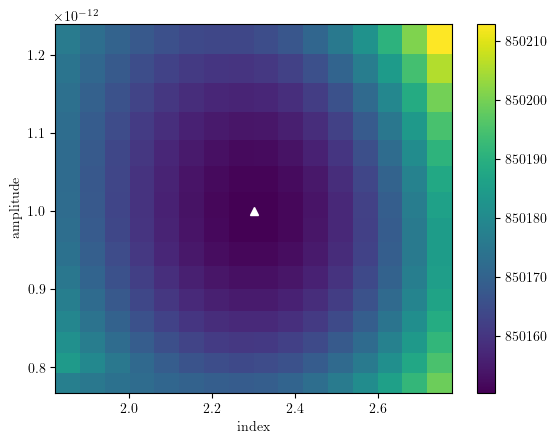

In [23]:
scan, x_scan, y_scan = read_L("amplitude", "index")
plot_imshow(scan, x_scan, y_scan, "amplitude", "index")

In [32]:
#source = list(contour.keys())[0][:-24]
amplix__ = x_scan.copy()
indexy__ = y_scan.copy()
N_new = 110
N_new_y = 100
amplix__new = np.linspace(amplix__[0], amplix__[-1], N_new)
indexy__new = np.linspace(indexy__[0], indexy__[-1], N_new_y)


f = interp2d(
    x=indexy__,
    y=amplix__,
    z=scan,
    kind="cubic",
    fill_value=None,
    bounds_error=False,
)
data_contour = f(indexy__new, amplix__new)


min index: 2.3045930099701257
min amplitude: 9.98299278561505e-13


Text(0.5, 1.0, 'Likelihood')

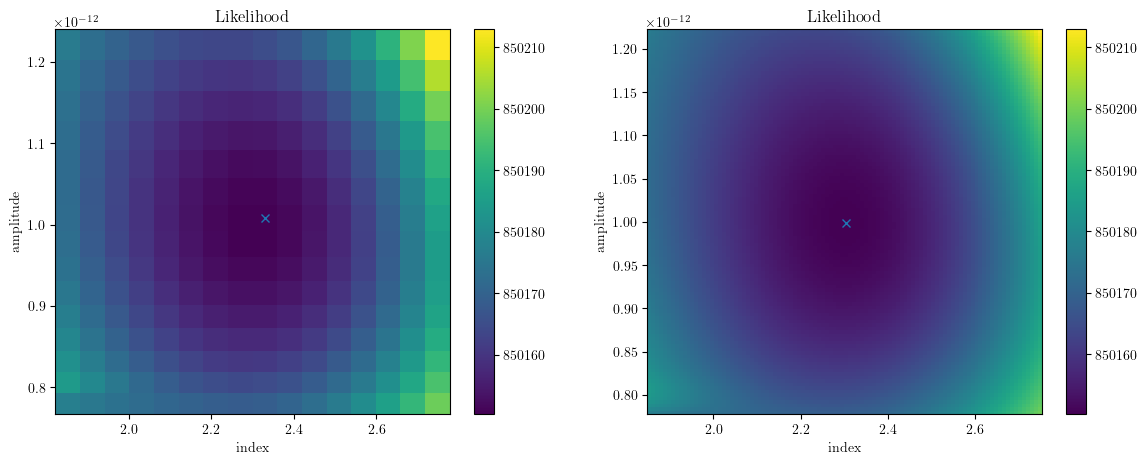

In [33]:
fig, (ax1, ax) = plt.subplots(1, 2, figsize=(14, 5))

#im = ax1.pcolormesh(amplix__, indexy__, scan)
im = ax1.pcolormesh(indexy__, amplix__, scan)

dddd = np.array(scan)
ampli_best = amplix__[np.where(dddd == dddd.min())[0][0]]
index_best = indexy__[np.where(dddd == dddd.min())[1][0]]

ax1.plot(index_best, ampli_best, "x")
fig.colorbar(im, ax=ax1)
ax1.set_ylabel("amplitude")
ax1.set_xlabel(
    "index",
)
ax1.set_title("Likelihood")


im = ax.pcolormesh(indexy__new, amplix__new, data_contour)
dddd = np.array(data_contour)
ampli_best = amplix__new[np.where(dddd == dddd.min())[0][0]]
index_best = indexy__new[np.where(dddd == dddd.min())[1][0]]
print("min index:", index_best)
print("min amplitude:", ampli_best)

ax.plot(index_best, ampli_best, "x")
fig.colorbar(im, ax=ax)
ax.set_ylabel("amplitude")
ax.set_xlabel(
    "index",
)
ax.set_title("Likelihood")

In [34]:
asimov_model = Models.read("data/1_model.yml")
asimov_model_N = Models.read("data/1_model_N.yml")

In [35]:

def plot_best_fit(ax, par1, par2):
    pp1, pp2 = asimov_model.parameters[par1], asimov_model.parameters[par2]
    ax.errorbar(pp1.value, pp2.value, xerr = pp1.error, yerr = pp2.error, color = 'yellow',capsize = (4),  )
    pp1, pp2 = asimov_model_N.parameters[par1], asimov_model.parameters[par2]
    ax.errorbar(pp1.value, pp2.value, xerr = pp1.error, yerr = pp2.error, color = 'blue', capsize = (4), )

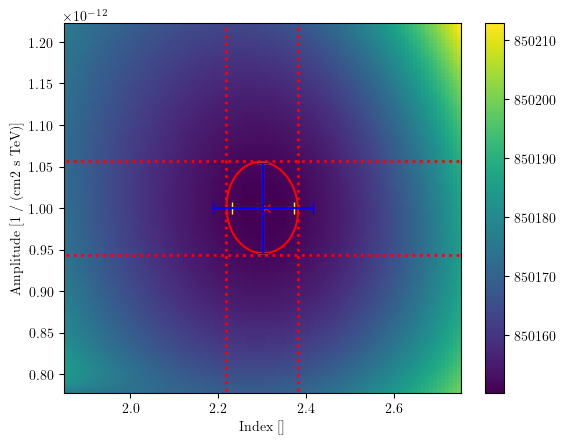

In [36]:
threshold_contour = 1

(
    ampli_min_asimov,
    ampli_max_asimov,
    index_min_asimov,
    index_max_asimov,
    ampli_best_asimov,
    index_best_asimov,
) = compute_errors(
    data_contour, indexy__new, amplix__new, threshold_contour, find_min=True
)
CS = plot_L(
    data_contour,
    indexy__new,
    amplix__new,
    threshold_contour,
    find_min=True,
    color="red",
)

dat = CS.allsegs[0][0]

plot_best_fit(plt.gca(), "index", "amplitude")